# Dmitriev Egor
e.dmitriev@innopolis.university | BS20-RO

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import sys

# setting path so we cam import src
sys.path.append('..')

## Explore given data

In [4]:
raw_df = pd.read_csv('../data/raw/filtered.tsv', sep='\t', index_col=0)
raw_df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


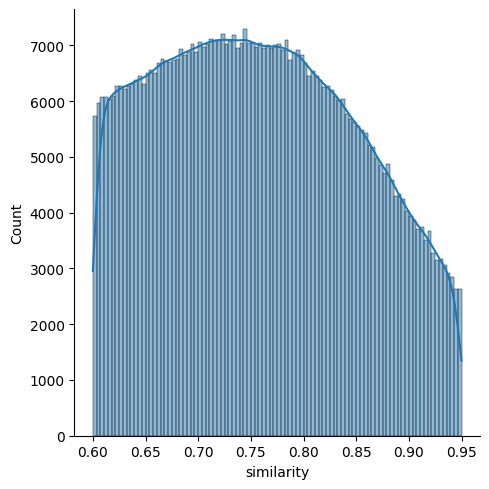

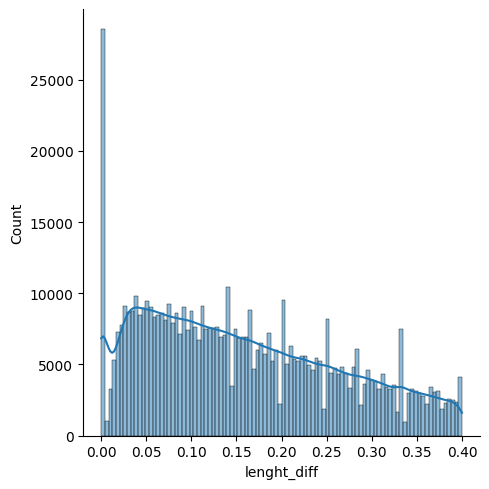

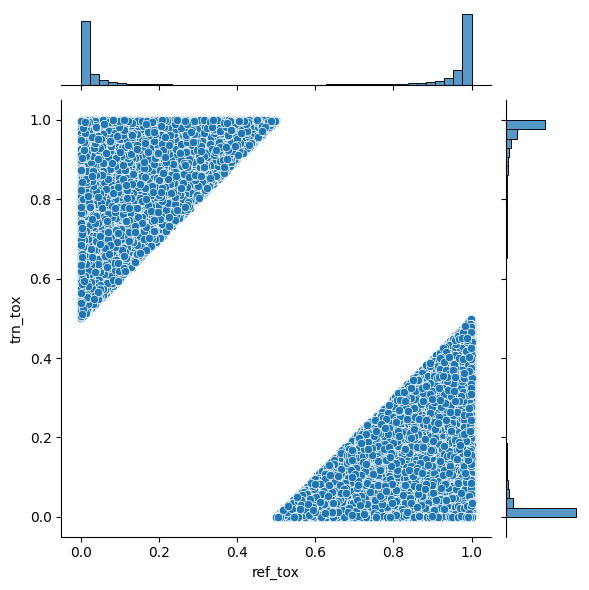

In [4]:
ax_similarity = sns.displot(raw_df, x='similarity', kde=True)
plt.savefig('../reports/figures/similarity_given_raw.png')
ax_len_diff = sns.displot(raw_df, x='lenght_diff', kde=True)
plt.savefig('../reports/figures/lenght_diff_given_raw.png')
ax_tox_diff = sns.jointplot(raw_df, x='ref_tox', y='trn_tox')
plt.savefig('../reports/figures/ref2trn_tox_given_raw.png')

## Dataset refining

In many cases translated text is more toxic than inital text.

In [5]:
raw_df[(raw_df['ref_tox'] < 0.2) & (raw_df['trn_tox'] > 0.8)].head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
8,"Briggs, what the hell's happening?","Briggs, what the hell is going on?",0.920373,0.000000,0.159096,0.841071


To fix it we can just swap the content of reference and translation.

In [6]:
orderd_df = raw_df.copy(deep=True)
filter = orderd_df["ref_tox"] < orderd_df["trn_tox"]
orderd_df.loc[filter, ['reference', 'translation', 'ref_tox', 'trn_tox']] =\
    orderd_df.loc[filter, ['translation', 'reference', 'trn_tox', 'ref_tox']].values


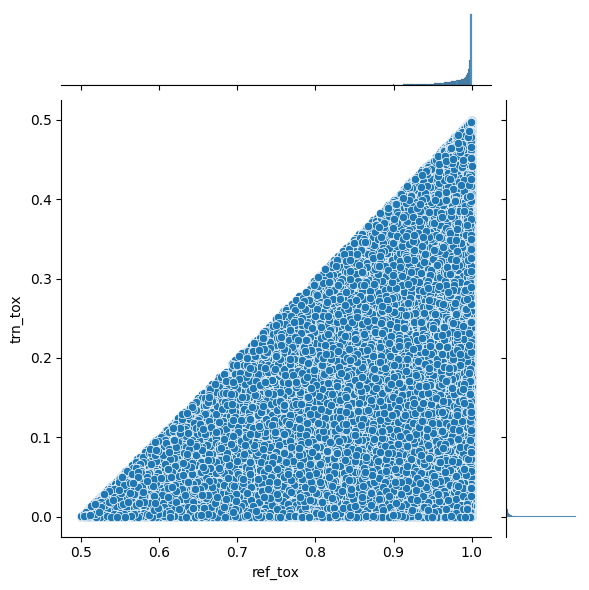

In [7]:
ax_tox_diff2 = sns.jointplot(orderd_df, x='ref_tox', y='trn_tox')
plt.savefig('../reports/figures/ref2trn_tox_given_ord.png')

Let's see how good our dataset at keeping similarity at various toxicity levels

In [7]:
from src.visualization.visualize import save_kde_reg_plot

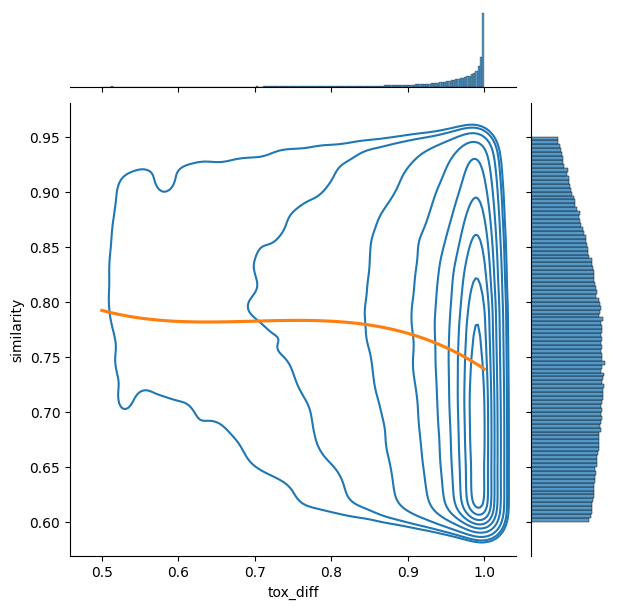

In [8]:
orderd_df['tox_diff'] = orderd_df['ref_tox'] - orderd_df['trn_tox']
save_kde_reg_plot(orderd_df, x='tox_diff', y='similarity', save_path='../reports/figures/toxdif2sim_given_ord.png')

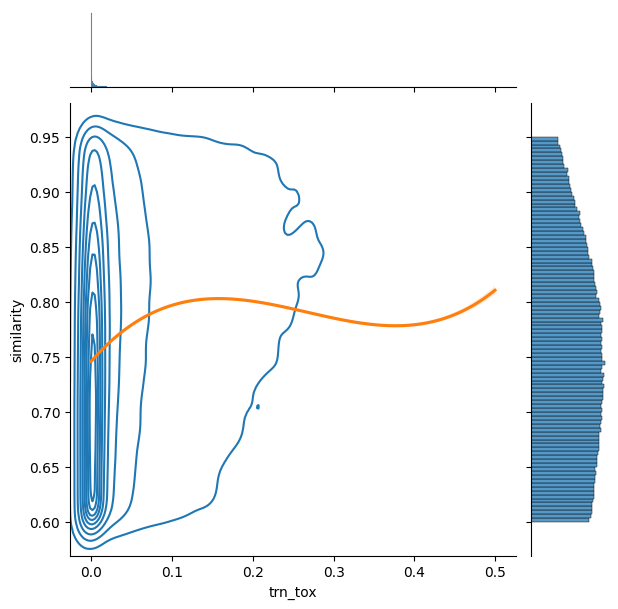

In [9]:
save_kde_reg_plot(orderd_df, x='trn_tox', y='similarity', save_path='../reports/figures/trntox2sim_given_ord.png')

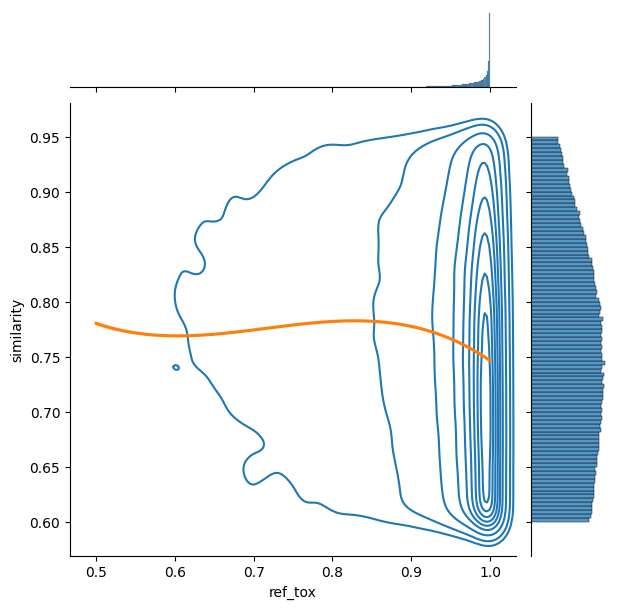

In [10]:
save_kde_reg_plot(orderd_df, x='ref_tox', y='similarity', save_path='../reports/figures/reftox2simgiven_ord.png')

As we can see the general tendency for similarity is to fall with growth of difference in toxisity. So let's cut off least similar records. 

In [8]:
truncated_df = orderd_df.copy(deep=True)
truncated_df = truncated_df[truncated_df["similarity"] > 0.8]
# truncated_df = truncated_df[truncated_df["ref_tox"] > 0.99]
# truncated_df = truncated_df[truncated_df["trn_tox"] < 0.01]
print(f'Dataset size: {len(orderd_df.index)} -> {len(truncated_df.index)}')

Dataset size: 577777 -> 200299


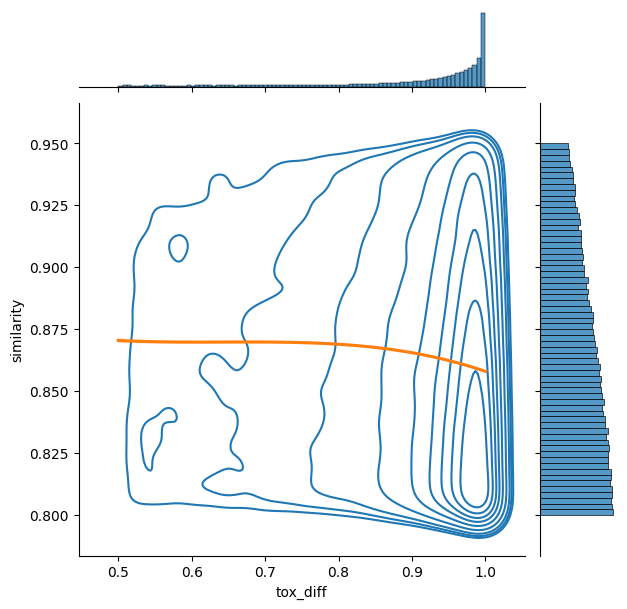

In [19]:
save_kde_reg_plot(truncated_df, x='tox_diff', y='similarity', save_path='../reports/figures/toxdif2sim_truncated_ord.png')

Looks good

In [ ]:
truncated_df['max_len'] = truncated_df[['reference', 'translation']].apply(lambda x : x.str.len()).max(axis=1)
# print(truncated_df['max_len'])

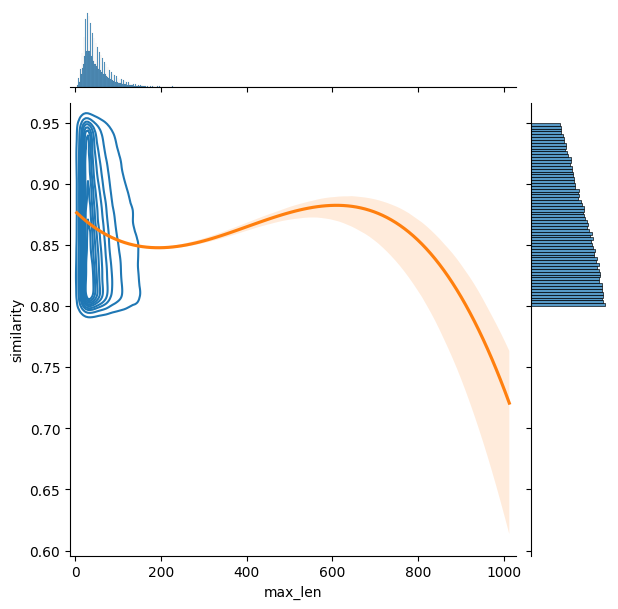

In [9]:
save_kde_reg_plot(truncated_df, x='max_len', y='similarity', save_path='../reports/figures/len2sim_truncated_ord.png')

There are some sentences with immense length but theres very few of them. They will bloat our model and hardly yield any good, so we can dicard them.

In [10]:
shortened_df = truncated_df.copy(deep=True)
shortened_df = shortened_df[shortened_df["max_len"] < 128]
print(f'Dataset size: {len(truncated_df.index)} -> {len(shortened_df.index)}')

Dataset size: 200299 -> 190358


## Save preprocessed dataset

In [11]:
from src.data.data import normalizeString

In [12]:
preprocessed_df = shortened_df.copy(deep=True)
preprocessed_df['reference'] = shortened_df['reference'].apply(normalizeString)
preprocessed_df['translation'] = shortened_df['translation'].apply(normalizeString)
preprocessed_df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,max_len
2,well we can spare your life,well we could spare your life for one,0.919051,0.268293,0.985068,0.213313,40
8,briggs what the hell is going on ?,briggs what the hell s happening ?,0.920373,0.000000,0.841071,0.159096,34
9,another simply didn t know what to do so whene...,another one simply had no clue what to do so w...,0.877540,0.101695,0.930472,0.055371,117
10,you d probably want me to buy you some chocola...,i suppose you want me to buy you flowers and c...,0.800661,0.160000,0.980341,0.000078,99
16,i m famous and you re dead,i m famous and you re done,0.817253,0.000000,0.979738,0.000926,28


In [13]:
preprocessed_df_path = '../data/interim/preprocessed.tsv'
preprocessed_df.to_csv(preprocessed_df_path, sep="\t") 